#approch
1.It first checks for matches based on the sequence of three input words (u, v, w) in the quadgram counts.

2.If no match is found, it falls back to trigrams, then bigrams, and finally unigrams.

3.For each possible next word, it calculates conditional probabilities, and the word with the highest probability is selected as the predicted next word.

**note** : model works gor uni,bi,tri,quadgram.

for prediction of 4th word give three word u,v,w as
"beginning","of", "the"

for prediction of 3rd word give input as :
"", "of" , "the"

for prediction of 2rd word give input as :
"", "" , "the"


#implementation

In [11]:
from collections import defaultdict
import re
import matplotlib.pyplot as plt
from collections import Counter

In [12]:
text_file_path = '/content/drive/MyDrive/Mahabharata_kisari_mohan_ganguly'

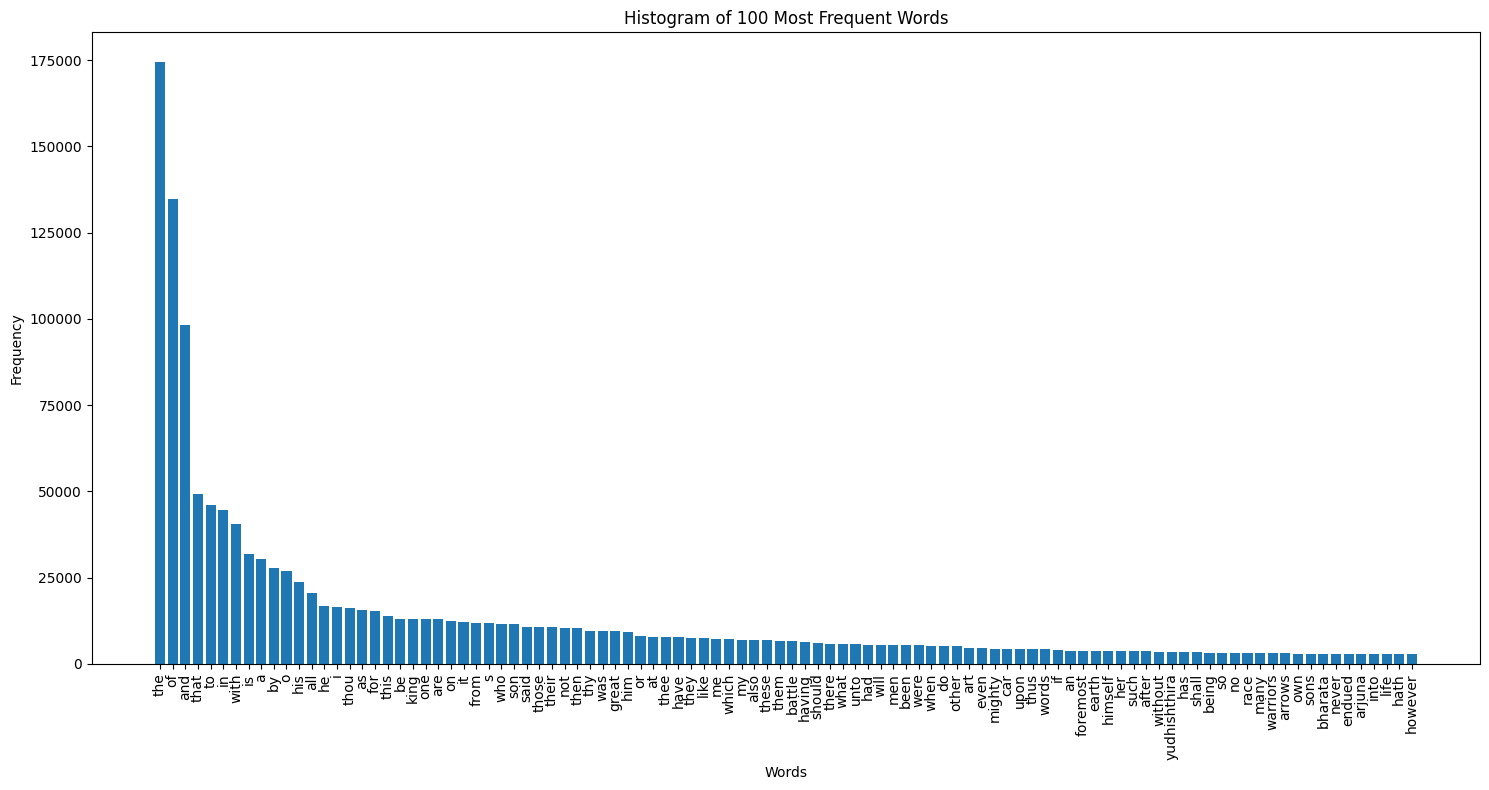

In [13]:
def plot_word_histogram(text_file_path, num_words=100):

  with open(text_file_path, 'r', encoding='utf-8') as f:
    text = f.read()

  words = re.findall(r'\b\w+\b', text.lower())
  word_counts = Counter(words)
  most_common_words = word_counts.most_common(num_words)

  word_labels = [word for word, count in most_common_words]
  word_counts = [count for word, count in most_common_words]

  plt.figure(figsize=(15, 8))
  plt.bar(word_labels, word_counts)
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.title(f'Histogram of {num_words} Most Frequent Words')
  plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
  plt.show()


plot_word_histogram(text_file_path)



# 1. Tokenize the text (considering only alphabate)

so in this step only taking a-z and A-Z and ignoreing all other symbols.

In [14]:
def tokenize_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.lower().split()
    return tokens

#2. frequency dictionaries for unigrams, bigrams, trigrams, and quadgrams.


1.here i created four dict to store uni,bi,tri and quadgram counts.
2.and used for loop to store it in dict.

In [15]:
def create_frequency_dicts(tokens):
    unigram_counts = defaultdict(int)
    bigram_counts = defaultdict(int)
    trigram_counts = defaultdict(int)
    quadgram_counts = defaultdict(int)

    for i in range(len(tokens)):
        unigram_counts[tokens[i]] += 1
        if i > 0:
            bigram_counts[(tokens[i-1], tokens[i])] += 1
        if i > 1:
            trigram_counts[(tokens[i-2], tokens[i-1], tokens[i])] += 1
        if i > 2:
            quadgram_counts[(tokens[i-3], tokens[i-2], tokens[i-1], tokens[i])] += 1

    return unigram_counts, bigram_counts, trigram_counts, quadgram_counts

# 3. Calculate the conditional probability P(x|uvw) for quadgrams with fallback to lower n-grams

**mathematical approch :**
so we have to calculate

**p(x/uvw) = p(xuvw)/p(uvw)**

**p(uvw) = p(w/uv).p(v/u).p(u)**

Quadgram Model: Calculates P(x∣uvw), corresponding to the first part of P(uvw).

Trigram Model: Calculates P(w∣uv) when no quadgram is available.

Bigram Model: Calculates P(v∣u) as a fallback if no trigram is available.

Unigram Model: Uses P(u) when no other n-grams are available.

here:
P(x∣uvw) = quadgram_counts/trigram_counts

In [16]:
def calculate_quadgram_prob_with_fallback(quadgram_counts, trigram_counts, bigram_counts, unigram_counts, u, v, w, vocab_size, alpha=1):
    def get_quadgram_prob(u, v, w, x):
        quadgram_count = quadgram_counts[(u, v, w, x)] + alpha
        trigram_count = trigram_counts[(u, v, w)] + (alpha * vocab_size)
        return quadgram_count / trigram_count if trigram_count > 0 else 0, quadgram_count

    def get_trigram_prob(v, w, x):
        trigram_count = trigram_counts[(v, w, x)] + alpha
        bigram_count = bigram_counts[(v, w)] + (alpha * vocab_size)
        return trigram_count / bigram_count if bigram_count > 0 else 0, trigram_count

    def get_bigram_prob(w, x):
        bigram_count = bigram_counts[(w, x)] + alpha
        unigram_count = unigram_counts[w] + (alpha * vocab_size)
        return bigram_count / unigram_count if unigram_count > 0 else 0, bigram_count

    def get_unigram_prob(x):
        return (unigram_counts[x] + alpha) / (sum(unigram_counts.values()) + (alpha * vocab_size)), unigram_counts[x]

    return get_quadgram_prob, get_trigram_prob, get_bigram_prob, get_unigram_prob

# 4. Predict the next word based on highest P(x|uvw) with fallback strategy

1. It starts by checking for potential quadgrams that match the given words u, v, and w.
2. If no quadgram matches are found, it falls back to trigrams and bigrams.
3.If no trigrams are found, it searches for bigrams.
4.If no bigrams are found, it defaults to unigrams.
5. It then calculates the conditional probability for each candidate word using the appropriate n-gram function.
6.The word with the highest probability is selected as the next word.

In [17]:
def predict_next_word_with_fallback(u, v, w, quadgram_counts, trigram_counts, bigram_counts, unigram_counts, vocab_size):

    possible_next_words = set([quad[3] for quad in quadgram_counts.keys() if quad[0] == u and quad[1] == v and quad[2] == w])

    if not possible_next_words:
        possible_next_words = set([tri[2] for tri in trigram_counts.keys() if tri[0] == v and tri[1] == w])

    if not possible_next_words:
        possible_next_words = set([bi[1] for bi in bigram_counts.keys() if bi[0] == w])

    if not possible_next_words:
        possible_next_words = set(unigram_counts.keys())

    # Calculate probabilities using the fallback strategy
    get_quadgram_prob, get_trigram_prob, get_bigram_prob, get_unigram_prob = calculate_quadgram_prob_with_fallback(
        quadgram_counts, trigram_counts, bigram_counts, unigram_counts, u, v, w, vocab_size
    )

    max_prob = 0
    best_word = None
    word_probabilities = []

    for x in possible_next_words:
        if (u, v, w, x) in quadgram_counts:
            prob, count = get_quadgram_prob(u, v, w, x)
        elif (v, w, x) in trigram_counts:
            prob, count = get_trigram_prob(v, w, x)
        elif (w, x) in bigram_counts:
            prob, count = get_bigram_prob(w, x)
        else:
            prob, count = get_unigram_prob(x)

        word_probabilities.append((x, prob, count))

        if prob > max_prob:
            max_prob = prob
            best_word = x

    print("\nPossible next words and their probabilities:")
    for word, prob, count in word_probabilities:
        print(f"Word: '{word}', Count: {count}, Probability: {prob:.4f}")

    return best_word, max_prob

# 5.predict the next word

1.Input: u, v, w (the last three words in the sequence)

Here,
 I gave three words u, v, w as "beginning", "of", "the".

The program predicts the 4th word and gives the probability of that word.

It also prints the count of each possible 4th word to give us an idea of how it works.

In [21]:
with open(text_file_path, 'r') as file:
    text_data = file.read()

tokens = tokenize_text(text_data)
unigram_counts, bigram_counts, trigram_counts, quadgram_counts = create_frequency_dicts(tokens)
vocab_size = len(unigram_counts)

# Input: u, v, w (the last three words in the sequence)
u, v, w = "beginning","of","the"

# Predict the next word
predicted_word, probability = predict_next_word_with_fallback(u, v, w, quadgram_counts, trigram_counts, bigram_counts, unigram_counts, vocab_size)

print(f"\nPredicted next word after '{u} {v} {w}': '{predicted_word}' with probability {probability:.4f}")



Possible next words and their probabilities:
Word: 'treta', Count: 3, Probability: 0.0001
Word: 'atharvan', Count: 2, Probability: 0.0001
Word: 'yuga', Count: 3, Probability: 0.0001
Word: 'welfare', Count: 2, Probability: 0.0001
Word: 'learned', Count: 2, Probability: 0.0001
Word: 'births', Count: 2, Probability: 0.0001
Word: 'kalpa', Count: 3, Probability: 0.0001
Word: 'nd', Count: 2, Probability: 0.0001
Word: 'world', Count: 2, Probability: 0.0001
Word: 'fortnight', Count: 2, Probability: 0.0001
Word: 'kali', Count: 3, Probability: 0.0001
Word: 'second', Count: 4, Probability: 0.0001
Word: 'yugas', Count: 2, Probability: 0.0001
Word: 'krita', Count: 2, Probability: 0.0001
Word: 'creation', Count: 4, Probability: 0.0001

Predicted next word after 'beginning of the': 'second' with probability 0.0001
